In [7]:
!pip install mcap-ros2-support mcap

In [19]:
from mcap_ros2.decoder import DecoderFactory
from mcap.reader import make_reader

magnetometer_data = []
printer_data = []
with open(
    "../data/rosbag2_2024_01_11-11_38_41/rosbag2_2024_01_11-11_38_41_0.mcap",
    "rb",
) as fd:
    reader = make_reader(fd, decoder_factories=[DecoderFactory()])
    for schema, channel, message, ros_msg in reader.iter_decoded_messages(
    ):
        # print(f"{channel.topic} {schema.name} [{message.log_time}]: ")
        if channel.topic == "/magnetometer_reading":
            for reading in ros_msg.magnetic_field_array:
                timestamp = reading.header.stamp.sec + reading.header.stamp.nanosec * 1e-9
                magnetic_field_x = reading.magnetic_field.x
                magnetic_field_y = reading.magnetic_field.y
                magnetic_field_z = reading.magnetic_field.z
                magnetometer_data.append([timestamp, magnetic_field_x, magnetic_field_y, magnetic_field_z])

        elif channel.topic == "/tf":
            for transform in ros_msg.transforms:
                if transform.header.frame_id == "printer_head_link":
                    timestamp = transform.header.stamp.sec + transform.header.stamp.nanosec * 1e-9
                    x = transform.transform.translation.x
                    y = transform.transform.translation.y
                    z = transform.transform.translation.z
                    printer_data.append([timestamp, x, y, z])

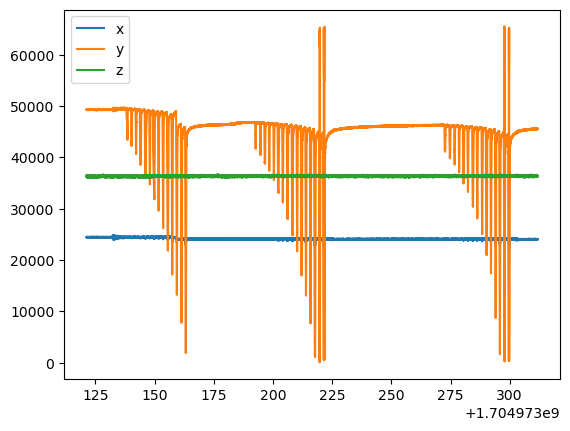

In [21]:
from matplotlib import pyplot as plt

plt.plot([x[0] for x in magnetometer_data], [x[1] for x in magnetometer_data], label="x")
plt.plot([x[0] for x in magnetometer_data], [x[2] for x in magnetometer_data], label="y")
plt.plot([x[0] for x in magnetometer_data], [x[3] for x in magnetometer_data], label="z")
plt.legend()
plt.show()

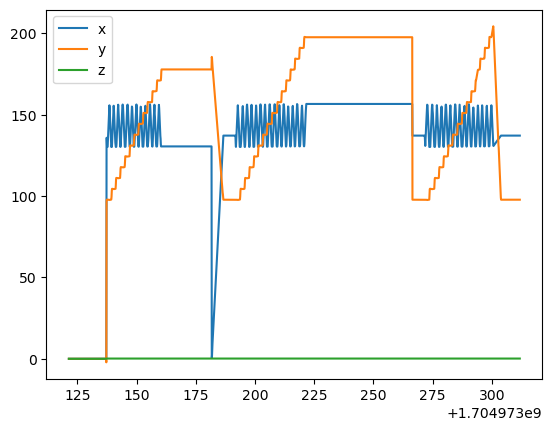

In [22]:
plt.plot([x[0] for x in printer_data], [x[1] for x in printer_data], label="x")
plt.plot([x[0] for x in printer_data], [x[2] for x in printer_data], label="y")
plt.plot([x[0] for x in printer_data], [x[3] for x in printer_data], label="z")
plt.legend()
plt.show()